In [1]:
println("Hello super people!")

Hello super people!


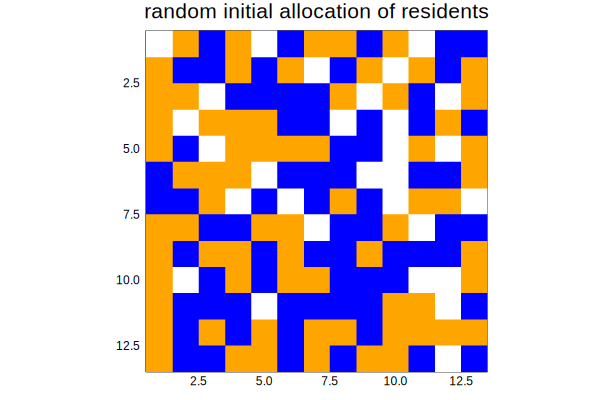

In [21]:
using Random, Plots

#define the grid
#schelling used originally 13x13 grid
GRID_SIZE = 13
CELL_COUNT = 13*13

THRESHOLD_SAME = 5
THRESHOLD_EDGE = 3
THRESHOLD_CORNER = 2

yellow_count = Int(round(CELL_COUNT * 5/(GRID_SIZE-1)))
blue_count = Int(round(CELL_COUNT * 5/(GRID_SIZE-1)))

empty_grid = zeros(GRID_SIZE,GRID_SIZE)
empty_grid[1:yellow_count] .= 1
empty_grid[yellow_count+1:yellow_count+blue_count] .= -1

start_grid = shuffle(empty_grid)

#random initial allocation heatmap viz
#yellow = -1, blue = 1
heatmap(start_grid,title="random initial allocation of residents",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))


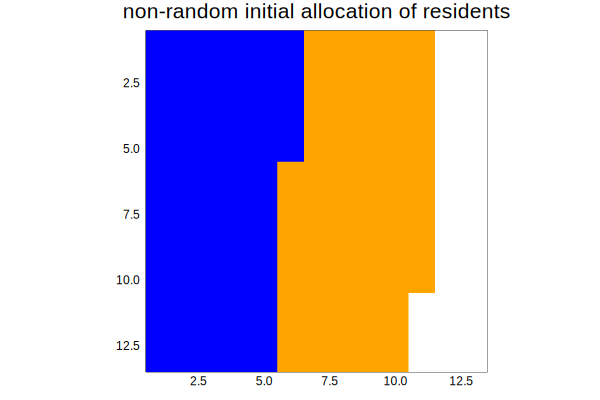

In [23]:
yellow_count = Int(round(CELL_COUNT * 5/(GRID_SIZE-1)))
blue_count = Int(round(CELL_COUNT * 5/(GRID_SIZE-1)))

empty_grid = zeros(GRID_SIZE,GRID_SIZE)
empty_grid[1:yellow_count] .= 1
empty_grid[yellow_count+1:yellow_count+blue_count] .= -1

set_grid = empty_grid#shuffle(empty_grid)

#random initial allocation heatmap viz
#yellow = -1, blue = 1
heatmap(set_grid,title="non-random initial allocation of residents",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))

In [26]:
#macrostate function mapping (eg, what is the total satisfaction of the residents overall the cells, total sum from zero to max)
#function overall_satisfaction(start_grid)


function grid_satisfaction(start_grid) 
cell_satisfaction = []

for row in 1:GRID_SIZE
    for col in 1:GRID_SIZE
        cell_surrounding = []
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            for ii in 0:2
                for jj in 0:2
                    if(!(ii==1 && jj==1))
                        append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                    end
               
                end
            end
            #println(cell_surrounding)
            if(start_grid[row,col] != 0)
                homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                if(homogeneous_count >= THRESHOLD_EDGE)
                    append!(cell_satisfaction,1)
                else
                    append!(cell_satisfaction,0)
                end
            else
                append!(cell_satisfaction,0)
            end
        end
        if((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            for ii in 0:1
                for jj in 0:1
                    if(!(ii==1 && jj==1))
                        append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                    end
               
                end
            end
            #println(cell_surrounding)
            if(start_grid[row,col] != 0)
                homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                if(homogeneous_count >= THRESHOLD_EDGE)
                    append!(cell_satisfaction,1)
                else
                    append!(cell_satisfaction,0)
                end
            else
                append!(cell_satisfaction,0)
            end
        end
        if((row==1 && col==1))#top left corner
            for ii in 1:2
                for jj in 1:2
                    if(!(ii==1 && jj==1))
                        append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                    end
               
                end
            end
            #println(cell_surrounding)
            if(start_grid[row,col] != 0)
                homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                if(homogeneous_count >= THRESHOLD_EDGE)
                    append!(cell_satisfaction,1)
                else
                    append!(cell_satisfaction,0)
                end
            else
                append!(cell_satisfaction,0)
            end
        end
        if((row==1 && col==GRID_SIZE))#top right corner
            for ii in 1:2
                for jj in 0:1
                    if(!(ii==1 && jj==1))
                        append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                    end
               
                end
            end
            #println(cell_surrounding)
            if(start_grid[row,col] != 0)
                homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                if(homogeneous_count >= THRESHOLD_EDGE)
                    append!(cell_satisfaction,1)
                else
                    append!(cell_satisfaction,0)
                end
            else
                append!(cell_satisfaction,0)
            end
        end
        if((row==GRID_SIZE && col==1))#bottom left corner
            for ii in 0:1
                for jj in 1:2
                    if(!(ii==1 && jj==1))
                        append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                    end
               
                end
            end
            #println(cell_surrounding)
            if(start_grid[row,col] != 0)
                homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                if(homogeneous_count >= THRESHOLD_EDGE)
                    append!(cell_satisfaction,1)
                else
                    append!(cell_satisfaction,0)
                end
            else
                append!(cell_satisfaction,0)
            end
        end
        if((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            for ii in 1:2
                for jj in 0:2
                    if(!(ii==1 && jj==1))
                        append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                    end
               
                end
            end
            #println(cell_surrounding)
            if(start_grid[row,col] != 0)
                homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                if(homogeneous_count >= THRESHOLD_EDGE)
                    append!(cell_satisfaction,1)
                else
                    append!(cell_satisfaction,0)
                end
            else
                append!(cell_satisfaction,0)
            end
        end
        if( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            for ii in 0:2
                for jj in 1:2
                    if(!(ii==1 && jj==1))
                        append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                    end
               
                end
            end
            #println(cell_surrounding)
            
            if(start_grid[row,col] != 0)
                homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                if(homogeneous_count >= THRESHOLD_EDGE)
                    append!(cell_satisfaction,1)
                else
                    append!(cell_satisfaction,0)
                end
            else
                append!(cell_satisfaction,0)
            end
            
        end
        if( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            for ii in 0:2
                for jj in 0:1
                    if(!(ii==1 && jj==1))
                        append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                    end
               
                end
            end
            #println(cell_surrounding)
            
            if(start_grid[row,col] != 0)
                homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                if(homogeneous_count >= THRESHOLD_EDGE)
                    append!(cell_satisfaction,1)
                else
                    append!(cell_satisfaction,0)
                end
            else
                append!(cell_satisfaction,0)
            end
            
        end
        if( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            for ii in 0:1
                for jj in 0:2
                    if(!(ii==1 && jj==1))
                        append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                    end
               
                end
            end
            #println(cell_surrounding)
            
            if(start_grid[row,col] != 0)
                homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                if(homogeneous_count >= THRESHOLD_EDGE)
                    append!(cell_satisfaction,1)
                else
                    append!(cell_satisfaction,0)
                end
            else
                append!(cell_satisfaction,0)
            end
            
        end
    end
end
#println(cell_satisfaction)
#println(size(cell_satisfaction))
#println(sum(cell_satisfaction))

    return sum(cell_satisfaction)
end

satisfiedOneGrid = grid_satisfaction(start_grid)
println("random grid satisfaction value=",satisfiedOneGrid)
println("set grid satisfaction value=",grid_satisfaction(set_grid))


random grid satisfaction value=76
set grid satisfaction value=140


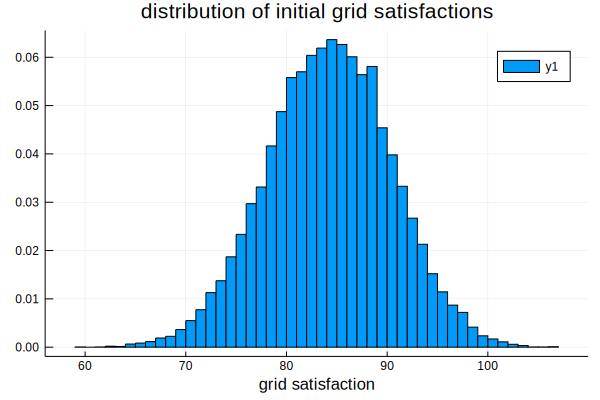

In [52]:
#sample the random intializations and investigate 
function make_random_grid()
    empty_grid = zeros(GRID_SIZE,GRID_SIZE)
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    random_grid = shuffle(empty_grid)
    return random_grid
end
numberOfRandomSamples = 20000
randomSatisfactions = [grid_satisfaction(make_random_grid()) for x in 1:numberOfRandomSamples]
normedRandomSatisfactions = randomSatisfactions ./ sum(randomSatisfactions)
histogram(randomSatisfactions,normalize=:probability,title="distribution of initial grid satisfactions",xlabel="grid satisfaction")

In [28]:
using Documenter


$$\lambda + \beta$$
$$\frac{12}{4}$$

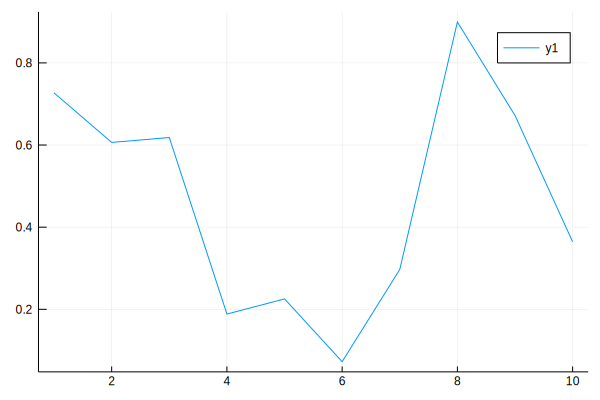

In [16]:
using Plots
plot(rand(10))

In [17]:
function f1(x)
    x = x^2
    return x+x
end

f1 (generic function with 1 method)

In [18]:
x=3
println(f1(x))

18
